# Breast Tumor Classification using Fine-Tuning the VGG16

### This below two cell must be executed to access data from drive (if it's stored on it ), if you want run it on Google Colab

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [44]:
cd drive/

/content/drive/drive/drive/drive


## Actual code starts from here

In [0]:
import os

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(320, 320, 3))

In [0]:
base_dir = '/content/drive/CV_dataset/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 10, 10, 512)       14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 27,822,401
Trainable params: 27,822,401
Non-trainable params: 0
_________________________________________________________________


In [50]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0         
__________

## Unfreezing the last three layers of VGG16 to fine-tune on our custom model

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## Augmenting the training data

In [52]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(320, 320), batch_size=8, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_dir, target_size=(320, 320), batch_size=8, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=25,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=8)

Found 179 images belonging to 2 classes.
Found 169 images belonging to 2 classes.
Epoch 1/50
25/25 [==============================] - 11s 453ms/step - loss: 0.7841 - acc: 0.4815 - val_loss: 0.7526 - val_acc: 0.4219
Epoch 2/50
25/25 [==============================] - 10s 419ms/step - loss: 0.7107 - acc: 0.5636 - val_loss: 0.6822 - val_acc: 0.5781
Epoch 3/50
25/25 [==============================] - 10s 419ms/step - loss: 0.7244 - acc: 0.5516 - val_loss: 0.6739 - val_acc: 0.4844
Epoch 4/50
25/25 [==============================] - 10s 417ms/step - loss: 0.6683 - acc: 0.6016 - val_loss: 0.6733 - val_acc: 0.5938
Epoch 5/50
25/25 [==============================] - 11s 421ms/step - loss: 0.6952 - acc: 0.5616 - val_loss: 0.6515 - val_acc: 0.6094
Epoch 6/50
25/25 [==============================] - 11s 449ms/step - loss: 0.6139 - acc: 0.6797 - val_loss: 0.6611 - val_acc: 0.6250
Epoch 7/50
21/25 [========================>.....] - ETA: 1s - loss: 0.6186 - acc: 0.597225/25 [=========================

## Saving the trained model

In [0]:
model.save('cancer_classification_fine-tuned_VGG16.h5')

## Plotting the training & validation accuarcy and loss values

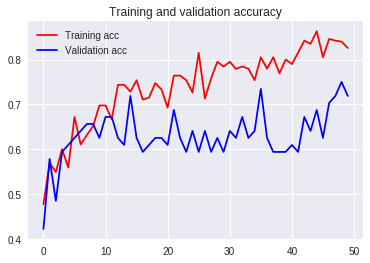

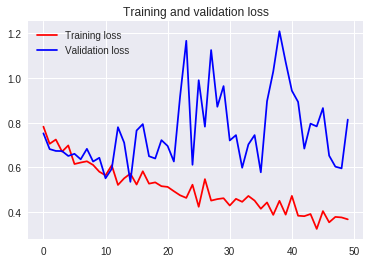

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()